<a href="https://colab.research.google.com/github/Ravitejaa249/DIP-project/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import os
from torchvision import transforms



from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Path to dataset
data_path = "/content/drive/MyDrive/AI-face-detection-Dataset"

# Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# Load dataset
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)


# Print class mappings
print("Class to Index:", full_dataset.class_to_idx)

# Split dataset into 80% train, 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Class to Index: {'AI': 0, 'real': 1}


In [ ]:
class DeepfakeCNN(nn.Module):
    def __init__(self):
        super(DeepfakeCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)  # 2 classes: Fake, Real
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = DeepfakeCNN().to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/deepfake_cnn.pth")


In [ ]:
# ... (previous code, including imports, model definition, training, etc.)

# Make sure full_dataset is defined (load your dataset)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import os

# Assuming data_path and transform are already defined
# data_path = "/content/drive/MyDrive/AI-face-detection-Dataset"
# transform = transforms.Compose(...)

full_dataset = datasets.ImageFolder(root=data_path, transform=transform)


def predict_image(image_path, model, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    output = model(image)
    _, predicted = torch.max(output, 1)
    return class_names[predicted.item()]

# Get class names from your dataset
class_names = full_dataset.classes

# Call predict_image with the correct arguments
result = predict_image("/content/b92f8fb9-a225-4975-bd3b-8c7a422dff6a.jpg", model, transform, class_names)
print("Prediction:", result)

Prediction: AI


In [ ]:
# ... (previous code, including imports, model definition, training, etc.)

def predict_image(image_path, model, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    output = model(image)
    _, predicted = torch.max(output, 1)
    return class_names[predicted.item()]

# Get class names from your dataset
class_names = full_dataset.classes

# Call predict_image with the correct arguments
result = predict_image("/content/WIN_20250328_14_02_30_Pro.jpg", model, transform, class_names)
print("Prediction:", result)

Prediction: real


Validation Accuracy: 99.69%

Confusion Matrix:
[[205   2]
 [  0 434]] 

Classification Report:
              precision    recall  f1-score   support

          AI       1.00      0.99      1.00       207
        real       1.00      1.00      1.00       434

    accuracy                           1.00       641
   macro avg       1.00      1.00      1.00       641
weighted avg       1.00      1.00      1.00       641

ROC AUC: 1.0000


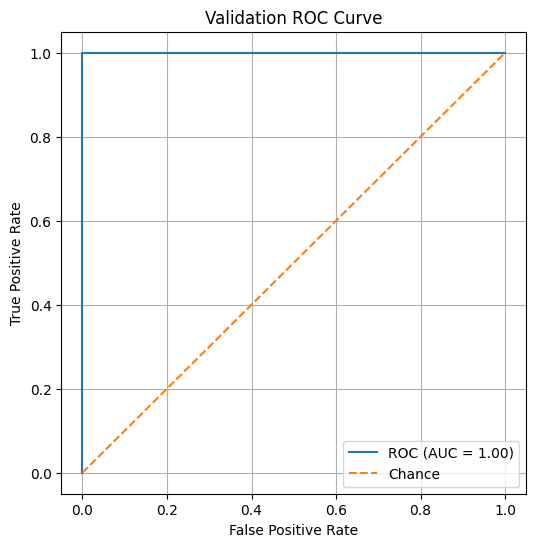

In [ ]:
import torch
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt

# ——— 1. Load your trained model weights on the correct device ———
model = DeepfakeCNN().to(device)

# this makes sure CUDA tensors get loaded onto CPU if CUDA isn’t available
checkpoint = torch.load(
    "/content/drive/MyDrive/deepfake_cnn.pth",
    map_location=device
)
model.load_state_dict(checkpoint)
model.eval()

# ——— 2. Collect ground-truths, predictions, and predicted probabilities ———
all_labels = []
all_preds  = []
all_probs  = []   # probability of “positive” class: e.g. class index 1

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)                     # raw logits
        probs   = torch.softmax(outputs, dim=1)[:,1] # P(class=1)
        preds   = outputs.argmax(dim=1).cpu().numpy()

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs.cpu().numpy())

# ——— 3. Compute metrics ———
acc    = accuracy_score(all_labels, all_preds)
cm     = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=class_names)

# ROC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# ——— 4. Print results ———
print(f"Validation Accuracy: {acc*100:.2f}%\n")
print("Confusion Matrix:")
print(cm, "\n")
print("Classification Report:")
print(report)

print(f"ROC AUC: {roc_auc:.4f}")

# ——— 5. Plot ROC curve ———
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], '--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



